Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
--- Random Forest ---
Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.93      0.88        92
         1.0       0.94      0.83      0.88       108

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.89      0.88      0.88       200



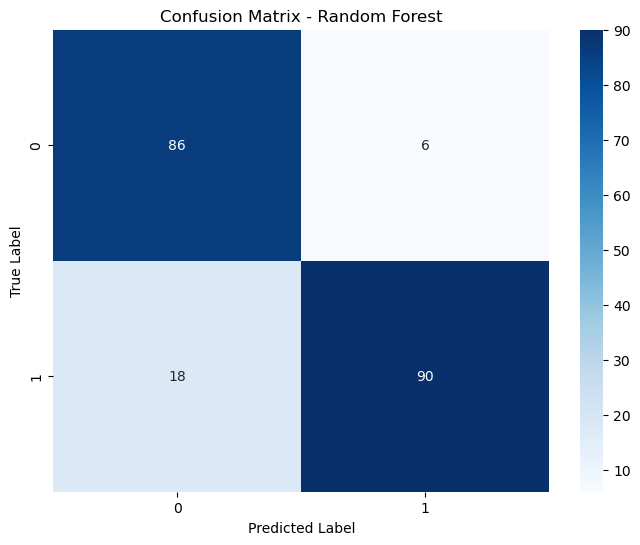

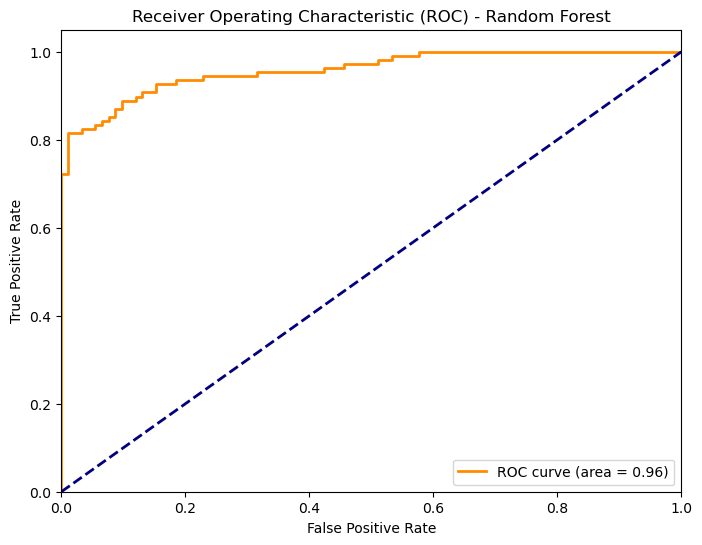

--- XGBoost ---
Accuracy: 0.905
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.97      0.90        92
         1.0       0.97      0.85      0.91       108

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.91       200



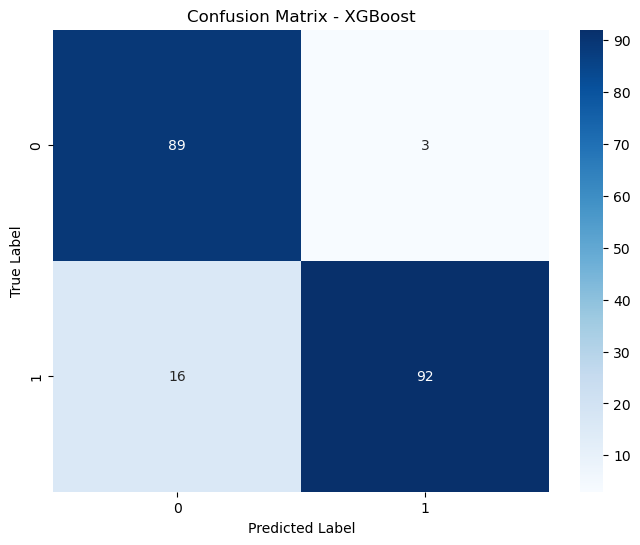


--- Model Comparison ---
Random Forest Accuracy: 0.8800
XGBoost Accuracy: 0.9050


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Generate balanced synthetic data with noise
def generate_synthetic_data(n_samples=1000):
    np.random.seed(42)  # for reproducibility
    
    # Generate normal data with slight noise
    n_normal = n_samples // 2
    heart_rate_normal = np.random.randint(60, 100, n_normal) + np.random.normal(0, 5, n_normal)
    spo2_normal = np.random.randint(95, 100, n_normal) + np.random.normal(0, 2, n_normal)
    labels_normal = np.zeros(n_normal)
    
    # Generate abnormal data with slight overlap
    n_abnormal = n_samples - n_normal
    heart_rate_abnormal = np.random.randint(50, 80, n_abnormal) + np.random.normal(0, 5, n_abnormal)
    spo2_abnormal = np.random.randint(85, 95, n_abnormal) + np.random.normal(0, 2, n_abnormal)
    labels_abnormal = np.ones(n_abnormal)
    
    # Combine normal and abnormal data
    heart_rate = np.concatenate([heart_rate_normal, heart_rate_abnormal])
    spo2 = np.concatenate([spo2_normal, spo2_abnormal])
    labels = np.concatenate([labels_normal, labels_abnormal])
    
    # Shuffle the data
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    heart_rate = heart_rate[indices]
    spo2 = spo2[indices]
    labels = labels[indices]
    
    df = pd.DataFrame({'heart_rate': heart_rate, 'spo2': spo2, 'label': labels})
    return df

# Preprocess the data for training
def preprocess_data(df):
    X = df[['heart_rate', 'spo2']]  # Features: heart rate and SpO₂
    y = df['label']  # Target: normal (0) or abnormal (1)

    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Train Random Forest model with hyperparameter tuning
def train_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
        'min_samples_split': [5],
        'min_samples_leaf': [2]
    }
    
    model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters for Random Forest:", grid_search.best_params_)
    return grid_search.best_estimator_

# Evaluate the model and plot metrics (Random Forest Only)
def evaluate_model_rf(model, X_test, y_test, model_name="Random Forest"):
    predictions = model.predict(X_test)
    
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy_score(y_test, predictions)

# Train XGBoost model with hyperparameter tuning
def train_xgboost(X_train, y_train):
    param_grid = {
        'n_estimators': [50],
        'max_depth': [3],
        'learning_rate': [0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }
    
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters for XGBoost:", grid_search.best_params_)
    return grid_search.best_estimator_

# Evaluate the model and plot metrics (XGBoost Only)
def evaluate_model_xgb(model, X_test, y_test, model_name="XGBoost"):
    predictions = model.predict(X_test)
    
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return accuracy_score(y_test, predictions)

# Main execution flow
if __name__ == '__main__':
    # Step 1: Generate balanced synthetic data with noise and overlap
    data = generate_synthetic_data()
    
    # Step 2: Preprocess the data
    X_train, X_test, y_train, y_test = preprocess_data(data)
    
    # Step 3: Train Random Forest model
    rf_model = train_random_forest(X_train, y_train)
    
    # Step 4: Train XGBoost model
    xgb_model = train_xgboost(X_train, y_train)
    
    # Step 5: Evaluate the models
    rf_accuracy = evaluate_model_rf(rf_model, X_test, y_test, model_name="Random Forest")
    # Step 6: Evaluate the models
    xgb_accuracy=evaluate_model_xgb(xgb_model, X_test, y_test, model_name="XGBoost")

    # Step 7: Compare the models
    print("\n--- Model Comparison ---")
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
    print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
